<a href="https://colab.research.google.com/github/karthikeya-io/image-cartoonization/blob/main/cartoon_Gan_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
# from generator import Generator  # Assuming you have the Generator class defined in a separate file


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, kernel_size=3),
            nn.InstanceNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, kernel_size=3),
            nn.InstanceNorm2d(in_channels),
        )

    def forward(self, x):
        return x + self.conv_block(x)

In [ ]:
class Generator(nn.Module):
    def __init__(self, in_channels, out_channels, num_residual_blocks=9):
        super(Generator, self).__init__()

        # Initial convolution block
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels, 64, kernel_size=7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
        ]

        # Downsampling
        in_features = 64
        out_features = in_features * 2
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, out_features, kernel_size=3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features
            out_features = in_features * 2

        # Residual blocks
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features // 2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_features, out_features, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features
            out_features = in_features // 2

        # Output layer
        model += [nn.ReflectionPad2d(3), nn.Conv2d(64, out_channels, kernel_size=7), nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

In [ ]:
def load_generator(model_path):
    generator = Generator(3, 3)
    generator.load_state_dict(torch.load(model_path))
    generator.eval()
    return generator.cuda()

def preprocess_image(image_path, image_size=256):
    img = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    return transform(img).unsqueeze(0)

def postprocess_image(tensor):
    img = tensor.detach().cpu().squeeze(0)
    img = (img + 1) / 2
    img.clamp_(0, 1)
    return transforms.ToPILImage()(img)


In [ ]:
def generate_cartoon_image(image_path, generator):
    input_image = preprocess_image(image_path).cuda()
    with torch.no_grad():
        output_image = generator(input_image)
    output_image = postprocess_image(output_image)
    return output_image


In [ ]:
generator_path = "/content/drive/MyDrive/cartooncyclegan/checkpoints/G_A2B_18.pth"
input_image_path = "000693.jpg"

generator = load_generator(generator_path)
# cartoon_image = generate_cartoon_image(input_image_path, generator)

# input_image = Image.open(input_image_path).convert("RGB")

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
# ax1.imshow(input_image)
# ax1.set_title("Input Image")
# ax1.axis("off")

# ax2.imshow(cartoon_image)
# ax2.set_title("Cartoon Image")
# ax2.axis("off")

# plt.show()


In [ ]:
import os

def process_all_images(folder_path, generator):
    image_filenames = os.listdir(folder_path)
    input_images = []
    cartoon_images = []

    for filename in image_filenames:
        image_path = os.path.join(folder_path, filename)
        input_image = Image.open(image_path).convert("RGB")
        input_images.append(input_image)

        cartoon_image = generate_cartoon_image(image_path, generator)
        cartoon_images.append(cartoon_image)

    return input_images, cartoon_images


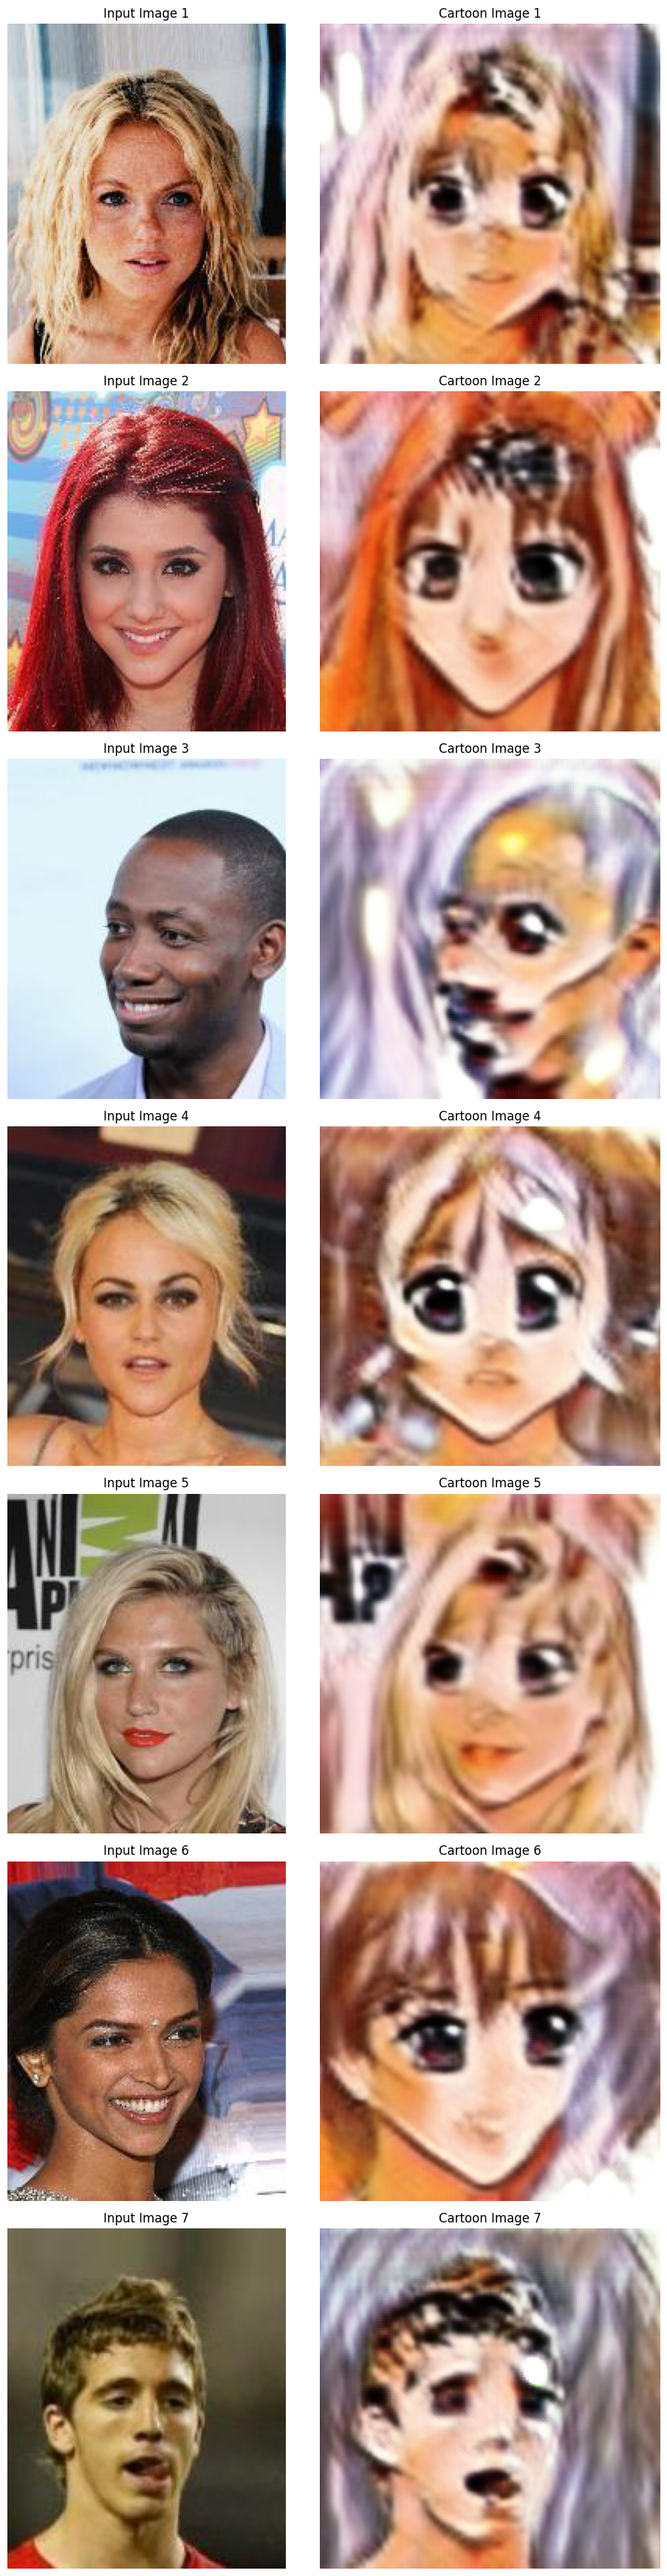

In [ ]:
input_images, cartoon_images = process_all_images('/content/drive/MyDrive/datasets/sample-test-celeb', generator)

n_images = len(input_images)
fig, axes = plt.subplots(n_images, 2, figsize=(10, 5 * n_images))

for i in range(n_images):
    axes[i, 0].imshow(input_images[i])
    axes[i, 0].set_title(f"Input Image {i + 1}")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(cartoon_images[i])
    axes[i, 1].set_title(f"Cartoon Image {i + 1}")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()